# Poole, Tarsitani & Clayton 2020 <br />**Cuban Son and Salsa (IEMP-CSS)**

*From the Interpersonal Entrainment in Music Performance (IEMP) corpus*

**Reference:**  Poole, A., Tarsitani, S., & Clayton, M. (2020, July 10). IEMP Cuban Son and Salsa. DOI: [10.17605/OSF.IO/SFXA2](https://doi.org/10.17605/OSF.IO/SFXA2)

**Dataset license:** [CC BY-NC-ND 4.0](https://osf.io/zj69b)
(I assume that extracting intervals counts as 'merely changing the format', and is not a derivative.)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from rhythmplot import *
from rhythmplot.helpers import drop_na

# Directory to all the raw data (included in this repository)
DATA_DIR = '../data/iemp_css'
ORIGINAL_DATA_DIR = f'{DATA_DIR}/original-data'

# Function to save figures: you can easily toggle this on/off globally
savefig = get_figure_saver(group='iemp_css', save_pdf=False, save_png=False)

## Background

The `IEMP-CSS` corpus is a collection of Cuban son and salsa recordings by the group Asere, a Havana based group of seven musicians. The original recordings were made in 2009 by Adrian Poole, and are publicly available as part of the Interpersonal Entrainment in Music Performance (IEMP) corpus (https://osf.io/37fws/). Five songs were recorded:

In [2]:
CSS_metadata = pd.DataFrame([
    dict(num=1, id='Song_1', title='El Cantante', genre='Son', clave='2:3 son', duration="7\'15", stereo_mix='https://osf.io/tzhfd'),
    dict(num=2, id='Song_2', title='Palo Santo', genre='Son', clave='3:2 son', duration="5\'58", stereo_mix='https://osf.io/z9uxs'),
    dict(num=3, id='Song_3', title='Yo Naci En Un Solar', genre='Rumba/Salsa', clave='3:2 rumba', duration="7\'45", stereo_mix='https://osf.io/syu7b'),
    dict(num=4, id='Song_4', title='Tumbao Sangreao', genre='Son', clave='2:3 son', duration="5\'20", stereo_mix='https://osf.io/cezr7'),
    dict(num=5, id='Song_5', title='Habanera', genre='Son', clave='2:3 son', duration="6\'53", stereo_mix='https://osf.io/fe6bs')
]).set_index('id')
CSS_metadata

,num,title,genre,clave,duration,stereo_mix
id,,,,,,
Song_1,1,El Cantante,Son,2:3 son,7'15,https://osf.io/tzhfd
Song_2,2,Palo Santo,Son,3:2 son,5'58,https://osf.io/z9uxs
Song_3,3,Yo Naci En Un Solar,Rumba/Salsa,3:2 rumba,7'45,https://osf.io/syu7b
Song_4,4,Tumbao Sangreao,Son,2:3 son,5'20,https://osf.io/cezr7
Song_5,5,Habanera,Son,2:3 son,6'53,https://osf.io/fe6bs


## Preprocessing

For each song,(see below), three annotations are provided: **metre annotations** "based on manually tapping the first beat of each cycle", **raw onset data** and **selected onset data**, "tabulated with metrical positions and other information". We use the raw onset data, which are split per instrument: "onset times for most instruments (vocals, crash cymbal and shakers were excluded) were extracted based on envelope characteristics using MIR Toolbox".

> Each CSS_[Recording]_Onsets_Raw.csv file contains the  raw onset data for all 
> instruments. In some cases these have been edited, so e.g. when the bongo is 
> played for half a track and the bell for the second half, only raw onsets from 
> the relevant time range are included in each column. Also, onset extraction of 
> the bell on song 5 uses different settings for different time ranges [...]
> Columns alternate between times and peak levels, e.g. Bass = time of bass 
> guitar onset, Bass peak = corresponding peak level

In [3]:
# Example: first onsets in Song 1 (it starts with a spoken introduction)
df = pd.read_csv(f'{ORIGINAL_DATA_DIR}/Song_1/CSS_Song1_Onsets_Raw.csv')
onsets = df[[c for c in df.columns if not c.endswith('peak')]]
onsets.head()

,Bass,Clave,Guitar,Tres,Bongos,Bell,Cajon,Conga,Trumpet
0,42.053690,278.341708,43.450510,43.615348,65.688889,276.846238,40.449487,41.874961,65.972955
1,42.296115,278.842562,46.462723,46.442251,65.879865,277.028109,41.178212,42.746861,66.418850
2,42.535768,279.049702,49.274543,49.349568,66.104993,277.203200,41.358699,43.269066,66.871378
3,42.975715,279.578510,51.229845,50.983572,67.356844,277.289063,41.875127,44.703581,68.298741
4,43.247475,279.771593,51.710341,51.172598,67.559424,277.426148,42.571815,45.199161,68.518859


In [4]:
# Some instruments of course have fewer onsets:
onsets.tail()

,Bass,Clave,Guitar,Tres,Bongos,Bell,Cajon,Conga,Trumpet
1897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431.554631,NaN
1898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431.733755,NaN
1899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,432.199869,NaN
1900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,433.137350,NaN
1901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,433.270826,NaN


In [5]:

def get_surface_intervals(onsets_df, min_diff=25/1000):
    """Combine onsets from all instruments, but discard those that are practically simultaneous"""
    surface = drop_na(np.msort(np.ravel(onsets_df.values)))
    not_simultaneous = np.where(surface[1:] > surface[:-1] + min_diff)[0] + 1
    not_simultaneous = np.r_[0, not_simultaneous]
    surface = surface[not_simultaneous]
    intervals = surface[1:] - surface[:-1]
    assert np.min(intervals) > min_diff
    return intervals

In [6]:
def extract_intervals_from_song(song_num):
    df = pd.read_csv(f'data/iemp-css/Song_{song_num}/CSS_Song{song_num}_Onsets_Raw.csv')
    onsets_df = df[[c for c in df.columns if not c.endswith('peak')]]

    group = f'iemp_css/song_{song_num}'
    base = f'iemp_css-song_{song_num}'

    # Store instruments separately
    concatenated = []
    onsets_df = df[[c for c in df.columns if not c.endswith('peak')]]
    for instrument in onsets_df.columns:
        onsets = onsets_df[instrument].dropna().values
        intervals = onsets[1:] - onsets[:-1]
        concatenated.extend(intervals.tolist())
        concatenated.append(np.nan)
        save_intervals(intervals, group, f'{base}-{instrument.lower()}')

    # Concatenate all instruments
    save_intervals(np.array(concatenated), group, f'{base}-concatenated')

    # Surface rhythm: all onsets of all instrument combined
    surface = get_surface_intervals(onsets_df)
    surface = np.r_[surface, np.nan]
    save_intervals(surface, group, f'{base}-surface')

# for song_num in range(1, 6):
#     extract_intervals_from_song(song_num)

In [7]:
# combine all songs
concatenated = []
surface = []
for song_num in range(1, 6):
    base = f'{DATA_DIR}/song_{song_num}/iemp_css-song_{song_num}'
    concat = np.loadtxt(f'{base}-concatenated-intervals.txt')
    surf = np.loadtxt(f'{base}-surface-intervals.txt')
    assert np.isnan(concat[-1]) and np.isnan(surf[-1])
    concatenated.extend(concat.tolist())
    surface.extend(surf.tolist())

# save_intervals(np.array(concatenated), 'iemp_css', 'iemp_css-concatenated')
# save_intervals(np.array(surface), 'iemp_css', 'iemp_css-surface')

## Visualize

Note: to store the figure, enable save_pdf or save_png in get_figure_saver.


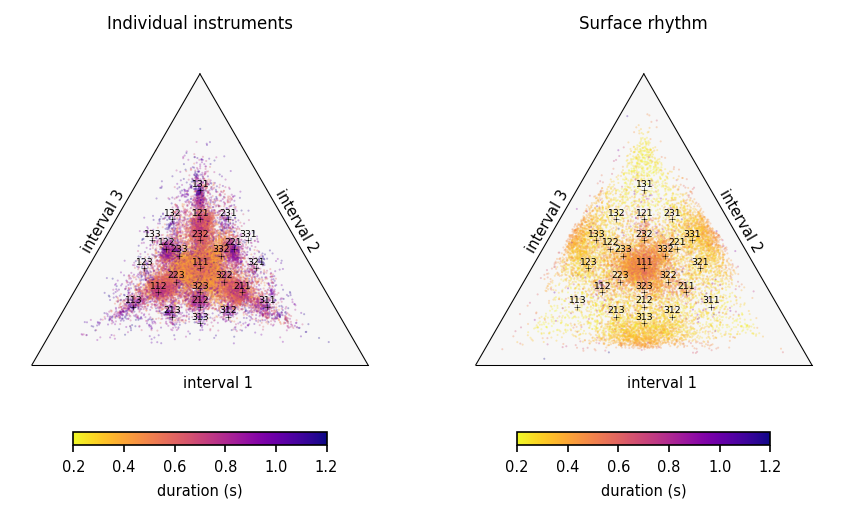

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))

kws = dict(min_dur=0.2, max_dur=1.2, plot_kws=dict(bottom_label_offset=-.2))
intervals = load_intervals('iemp_css', 'iemp_css-concatenated')
motifs, duration = normalize(ngram_motifs(intervals, length=3))
ternary_motif_plot(motifs, duration, ax=ax1, **kws)
ax1.set_title('Individual instruments', fontsize=8)

intervals = load_intervals('iemp_css', 'iemp_css-surface')
motifs, duration = normalize(ngram_motifs(intervals, length=3))
ternary_motif_plot(motifs, duration, ax=ax2, **kws)
ax2.set_title('Surface rhythm', fontsize=8)

savefig('separated-vs-surface')

Note: to store the figure, enable save_pdf or save_png in get_figure_saver.


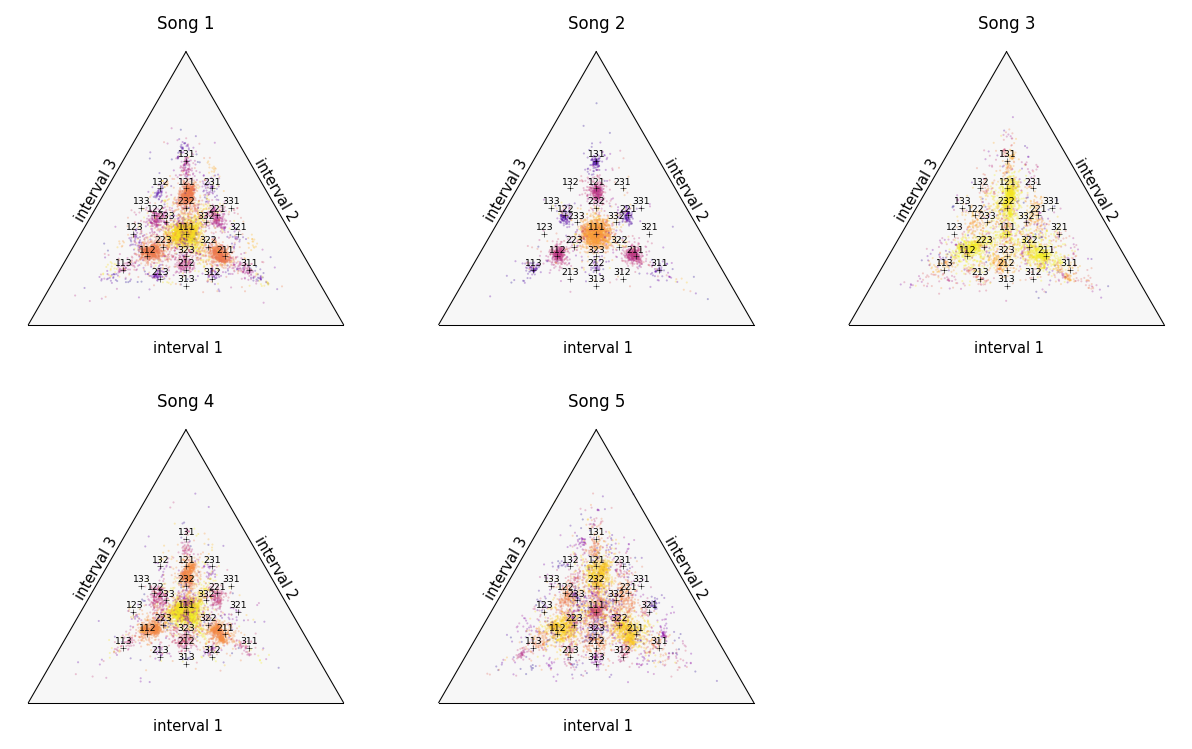

In [9]:
# Different songs
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

for song_num in range(1, 6):
    ax = axs.ravel()[song_num-1]
    intervals = load_intervals(f'iemp_css/song_{song_num}', f'iemp_css-song_{song_num}-concatenated')
    motifs, duration = normalize(ngram_motifs(intervals, length=3))
    ternary_motif_plot(motifs, duration, min_dur=0.5, max_dur=1.2, ax=ax, cbar=False, plot_kws=dict(dpi=150))
    ax.set_title(f'Song {song_num}', fontsize=8)
axs[-1,-1].axis('off')

savefig('per-song')

Note: to store the figure, enable save_pdf or save_png in get_figure_saver.


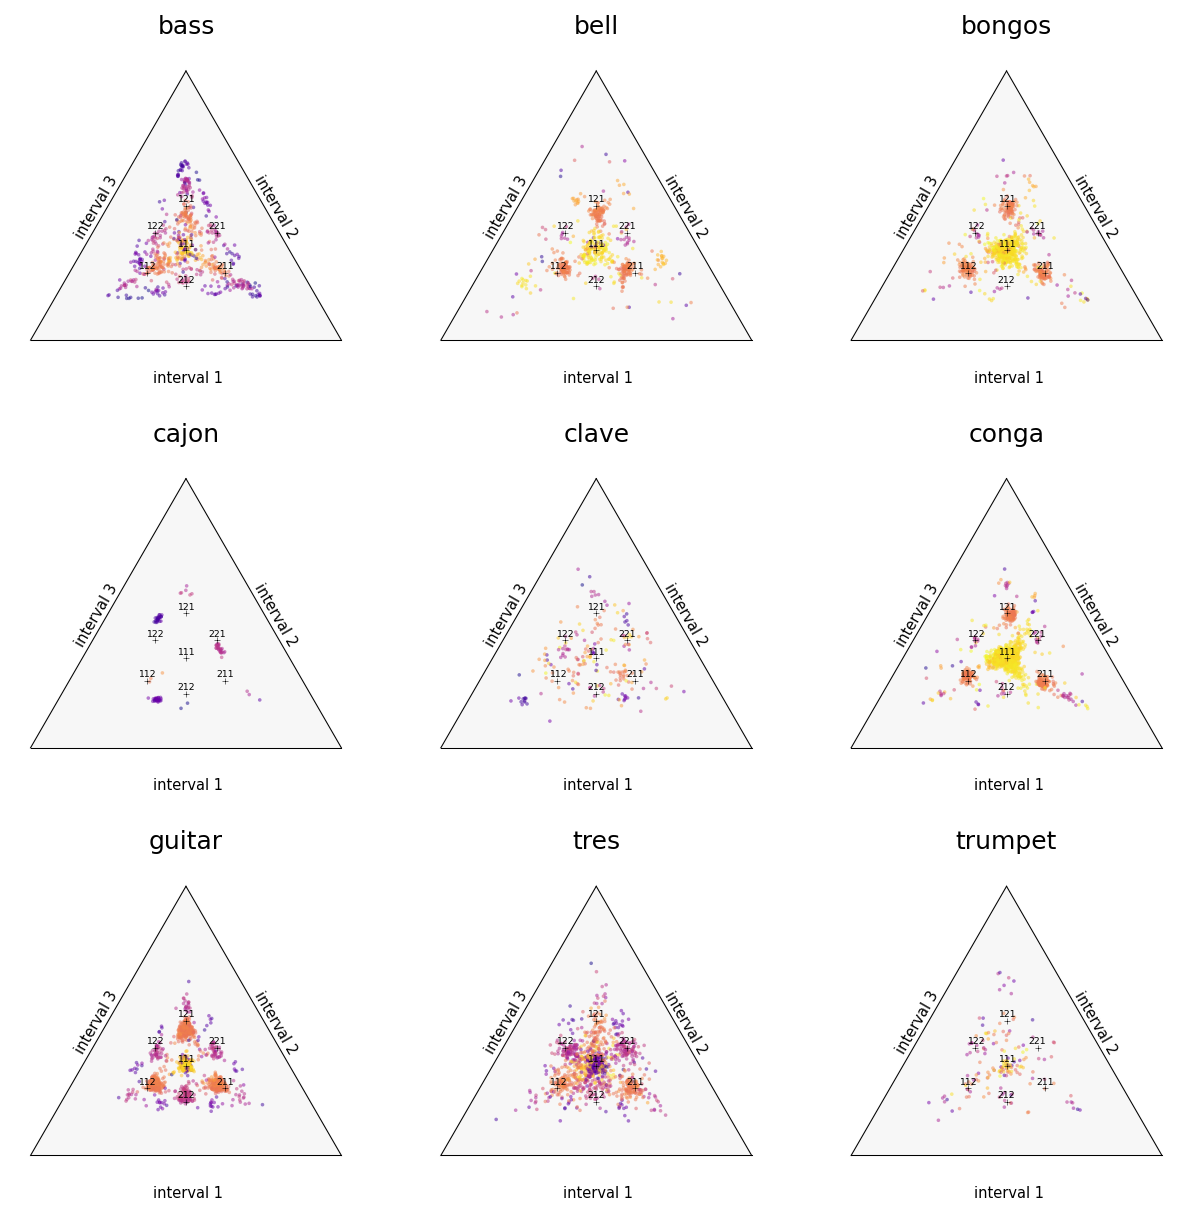

In [10]:
# Different instruments
instruments = {1: ['bass', 'bell', 'bongos', 'cajon', 'clave', 'conga', 'guitar', 'tres', 'trumpet']}
song_num = 1
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, instrument in enumerate(instruments[song_num]):
    ax = axs.ravel()[i]
    intervals = load_intervals(f'iemp_css/song_{song_num}', f'iemp_css-song_{song_num}-{instrument}')
    motifs, duration = normalize(ngram_motifs(intervals, length=3))
    ternary_motif_plot(motifs, duration, min_dur=0.5, max_dur=1.2, ax=ax, 
        scatter_kws=dict(s=3, alpha=.5),
        cbar=False, plot_kws=dict(dpi=150), ratio_kws=dict(factors=[1,2]))
    ax.set_title(f'{instrument}')

for ax in axs.ravel(): ax.axis('off')

savefig('song_1-per-instrument')